# Classification


Ceci est un extrait du chapitre 3 du livre d'Aurélien Géron: "Hands-On Machine Learning with Scikit-Learn and TensorFlow". Disponible sur amazon (en anglais et en français) pour un tout petit prix. Et [ici](https://github.com/ageron/handson-ml) se trouve le projet github correspondant. 

In [0]:
"to load assets on the server (if it was not already done)"
import os
if not os.path.exists("assets_ml"):
    !git clone https://github.com/vincentvigon/assets_ml
else:
    print('assets already here')

assets already here


In [0]:
%reset -f

In [0]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

"sklearn models"
import sklearn.datasets
import sklearn.linear_model
import sklearn.ensemble
import sklearn.neighbors
"sklearn utilities"
import sklearn.metrics
import sklearn.model_selection
import sklearn.base


plt.style.use("default")
np.set_printoptions(linewidth=500,precision=2)
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


assert os.path.exists("assets_ml"), "please download data"

##  MNIST data



### import data

70 000 images de 28*28 pixel écrite à la main, représentant des chiffres à retrouver. 

C'est le "Helleo world" du machine learning. 



In [0]:
import keras.datasets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [0]:
X_train.shape,y_train.shape,X_train.dtype,y_train.dtype

((60000, 28, 28), (60000,), dtype('uint8'), dtype('uint8'))

In [0]:
np.min(X_train[0,:,:]),np.max(X_train[0,:,:])

(0, 255)

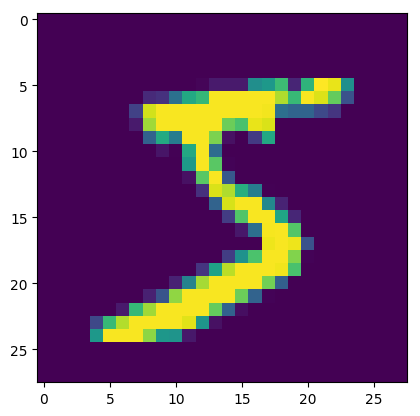

In [0]:
plt.imshow(X_train[0,:,:])

In [0]:
"""the data are randomized"""
print(y_train[:50])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6 0 7 6 1 8 7 9 3 9 8 5 9 3]


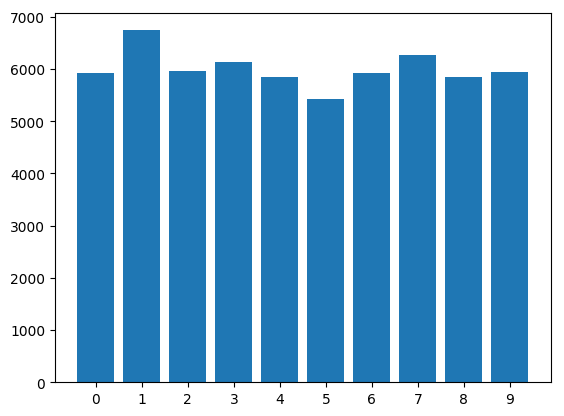

In [0]:
"almost the same instance number for each digit"
val,count=np.unique(y_train,return_counts=True)
plt.bar(val,count);
plt.xticks(val);

### Plot data


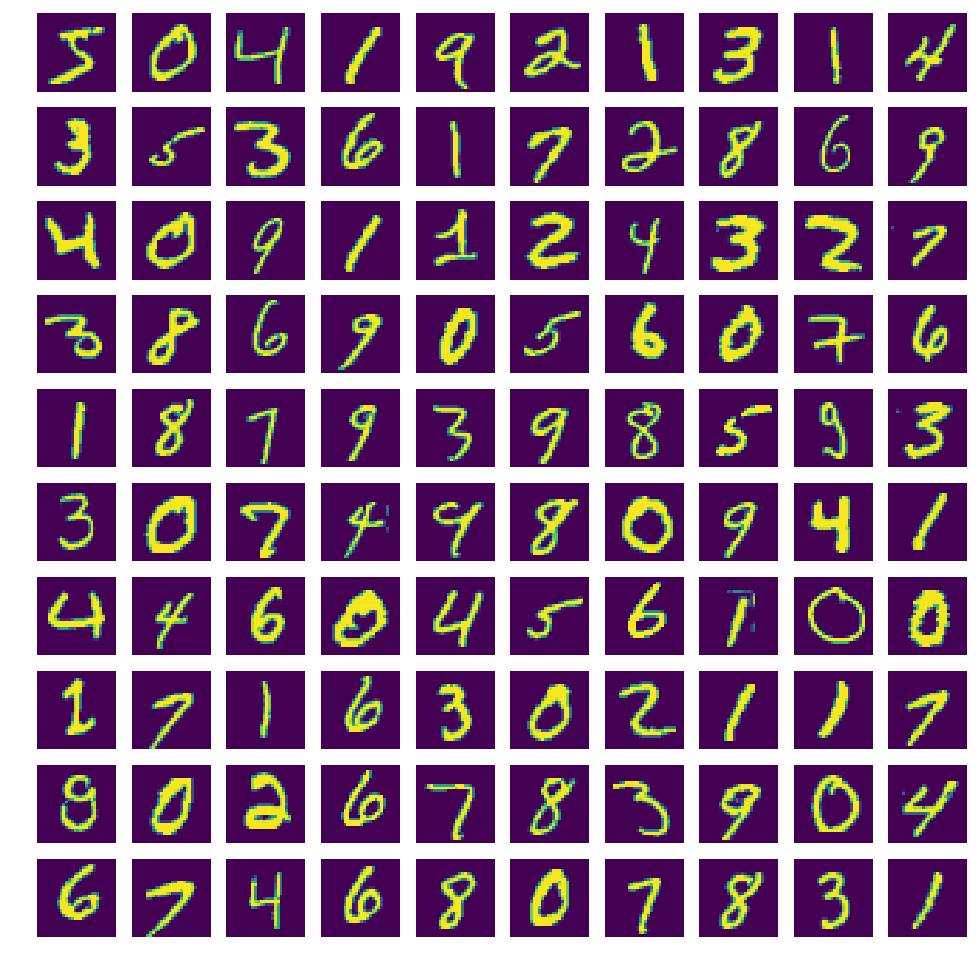

In [0]:
fig,axs=plt.subplots(10,10,figsize=(12,12))
axs=axs.flatten()
for i,ax in enumerate(axs):
    ax.imshow(X_train[i,:,:])
    ax.axis("off")

## Une classification binaire

On crée 2 classes:

* les images qui représente un 5 
* et celles qui representent autre chose qu'un 5.

In [0]:
y_bin_train = (y_train == 5).astype(np.int)
y_bin_test = (y_test == 5).astype(np.int)
print(y_bin_train[:50])

[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


### Stochastic Gradient Descent (SGD) classifier

C'est le classifier binaire le plus élémentaire: une régression logistique, mais entrainé avec une descente de gradient stochastique:

On passe les données une à une, et on bouge à chaque fois les paramètres (=les poids) $w,b$ pour diminuer la loss.


In [0]:
"""We want reproducible results, so set the random_state parameter"""
sgd_clf = sklearn.linear_model.SGDClassifier(random_state=42,max_iter=5,tol=1e-3)
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Détaillons les attributs de notre `SGDClassifier`:


* `shuffle=True`: On randomise l'ordre données

* `class_weight`: pour donner plus d'importance à certaines classes

* `early_stopping=False`: si true, à la fin on revient sur les poids qui ont minimisé la loss calculée sur les données de validation 

* `validation_fraction=0.1`

* `fit_intercept`: Expliquez $(1\heartsuit)$


---

La loss:

* `loss="hinge"`: le type de loss. Retenons surtout: 
  * `"log"`: modèle logistique, on prédit une probabilité
  * `"hinge"`: modèle SVM, on cherche le meilleurs plan séparant les deux classes. 


* `alpha`: le coefficient devant la pénalisation

* `penalty="l2"`: Le type de pénalisation:
  * `"none"`:pas de pénalisation 
  * `"l2"`: pénalisation Ridge. Expliquez $(1\heartsuit)$
  * `"l1"`: pénalité lasso. Expliquez $(1\heartsuit)$
  * `"elasticnet"`: on met  les deux pénalité l1 et l2. La proportion de l1 est controlée par le paramètre `l1_ratio`. En particulier si  `l1_ratio`=0 on retombe sur l2, et si  `l1_ratio`=1 on retombe sur l1.  


---

Décroissance du learning rate:

* `learning_rate="optimal"`: La manière dont on fait décroitre le learning rate, noté ici "eta".
  *  `"constant"`: eta = eta0, il ne bouge pas.  
  * `"optimal"`:  eta = 1.0 / (alpha * (t + t0)), où t et l'index d'itération, et t0 une constante calculée à partir d'une heuristique. 
  * `"invscaling"`: eta = eta0 / pow(t, power_t)
* `eta0`:  le learning rate initial dans les algo `"constant"` et `"invscaling"`. Notons que la valeur par défaut `0` est vraiment très étrange??? 
* `power_t` le paramètre utilisé dans la technique `"invscaling"`.

---

On Arrête de l'apprentissage quand : 

* ou bien quand on a  :  `loss > previous_loss - tol` (=1e-3) durant `n_iter_no_change` (=5)

* ou bien quand le nombre d'époque dépasse `max_iter` (=5)

---


* `warm_start=False`: Si on le met à True, le prochain appel de la fonction `.fit()` repart avec les paramètres $w$ calculés par l'appel précédent. 





In [0]:
X_train_flat=X_train.reshape([-1,28*28])
X_test_flat=X_test.reshape([-1,28*28])

X_train_flat.shape,X_test_flat.shape

((60000, 784), (10000, 784))

In [0]:
sgd_clf.fit(X_train_flat, y_bin_train)
print("nombre d'itération effectuée:",sgd_clf.n_iter_)

nombre d'itération effectuée: 5


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


***A vous:***  la méthode `fit()` nous renvoie le warning suivant:

    ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

Expliquez-le $(1\heartsuit)$.

###  Accuracy

In [0]:
hat_y_bin_test=sgd_clf.predict(X_test_flat)
np.mean( hat_y_bin_test == y_bin_test)

0.9694

96% d'accuracy. ça a l'air génial mais ...

Comparons avec le classifier trivial qui prédit toutjours la classe "non-5"


In [0]:
np.mean( np.zeros_like(y_bin_test) == y_bin_test)

0.9108

Ainsi, l'accuracy peut-être trompeuse. 

##  Classification  Multi-classe

Certains algo de classification sont naturellement multi-classes (random forest, réseau de neurone terminant par un softmax,...). Mais d'autre sont uniquement binaire. 

Mais il y a deux stratégies pour classer nos digit avec un classifier binaire:

* ***one-versus-all (OvA):*** on entraine un classifier binaire par digit:  il décide si une image représente ce digit ou un autre. Ensuite, quand on veut classer une image, on fait tourner les 10 classifier, et on choisi celui qui donne la meilleur proba. 


* ***one-versus-one (OvO):*** On entraine un classifier binaire pour chaque pair. Cela fonctionne quand le nombre de paire n'est pas trop grand. 



In [0]:
sgd_clf = sklearn.linear_model.SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train_flat, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [0]:
hat_y_test=sgd_clf.predict(X_test_flat)

In [0]:
np.mean(hat_y_test==y_test)

0.888

Essayons avec un `RandomForestClassifier`: 

In [0]:
forest_clf=sklearn.ensemble.RandomForestClassifier(verbose=True)
forest_clf.fit(X_train_flat,y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished


In [0]:
hat_y_test_forest=forest_clf.predict(X_test_flat)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [0]:
np.mean(hat_y_test_forest==y_test)

0.9487

##  Analyse de l'erreur

Bien sur, dans un projet complet de machine learning il faut:

* Tester différentes préparation des données (resclaling, ACP, suppression de valeurs abhérentes ...)

* Essayez différents modèles

* Garder les plus prometteurs

* ajuster les paramètres et sélectionner le modèle avec de la cross-validation et des recherche en grille ou aléatoire. 

Et tout l'art est de trouver le bon compromis entre: 

* tout automatiser (et risquer de mal comprendre les choses) 
* tout faire à la main (et y passer toutes ses nuits)

Supposons que l'on a déjà choisi des modèles prometteurs. On aimerait analyser leur erreurs "à la main" pour tenter de les améliorer. 

En premier lieu, il faut regarder la matrice de confusion

### Matrice de confusion

Les colonnes représente les `true label` et les ligne les `predicted label`. Si cette matrice est diagonale: on a tout bon.  

In [0]:
conf_mx = sklearn.metrics.confusion_matrix(y_test, hat_y_test)
print(conf_mx)

[[ 947    0    4    9    1    3   10    2    2    2]
 [   0 1069   32    6    0    4   10    2   10    2]
 [   7    0  923   28   10    1   17   11   31    4]
 [   3    0   18  924    3   26    3   14   10    9]
 [   3    0    3    5  919    0   16    4    4   28]
 [  14    2    6   72   18  698   28   10   22   22]
 [   7    2    6    6    3    9  924    0    1    0]
 [   5    4   24    6    6    2    0  955    3   23]
 [  15    7   28   73   21   43   34   24  715   14]
 [   9    4    2   17   60    9    1   94    7  806]]


***A vous:*** $(4\heartsuit)$ Faites un petit programme qui re-calcul cette matrice de confusion. C'est un bon exercicre de programmation avec numpy. 

Pour faire apparaitre des proportion: on divise chacune des valeurs par le nombre d'image dans la classe correspondante

In [0]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
print("row_sums.shape:",row_sums.shape) #sans keepdims=True on aurait shape=(10)
norm_conf_mx = conf_mx / row_sums
print(norm_conf_mx)

row_sums.shape: (10, 1)
[[0.97 0.   0.   0.01 0.   0.   0.01 0.   0.   0.  ]
 [0.   0.94 0.03 0.01 0.   0.   0.01 0.   0.01 0.  ]
 [0.01 0.   0.89 0.03 0.01 0.   0.02 0.01 0.03 0.  ]
 [0.   0.   0.02 0.91 0.   0.03 0.   0.01 0.01 0.01]
 [0.   0.   0.   0.01 0.94 0.   0.02 0.   0.   0.03]
 [0.02 0.   0.01 0.08 0.02 0.78 0.03 0.01 0.02 0.02]
 [0.01 0.   0.01 0.01 0.   0.01 0.96 0.   0.   0.  ]
 [0.   0.   0.02 0.01 0.01 0.   0.   0.93 0.   0.02]
 [0.02 0.01 0.03 0.07 0.02 0.04 0.03 0.02 0.73 0.01]
 [0.01 0.   0.   0.02 0.06 0.01 0.   0.09 0.01 0.8 ]]




En notant $\imath$ les vraie instances de la $i$ème-classe et $\hat \imath$ les instances prédites dans cette même classe, nous avons tracé la matrice dont les coefficients sont:
$$
\frac {\imath \cap \hat \jmath}{\imath}
$$
Ainsi on a affiché une proportion qui, en classification binaire, s'appellerait:

* le rappel ? 
* la précision ?



### En couleur



In [0]:
def plot_mat(conf_mx):
    plt.matshow(conf_mx)
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.grid(False)
    plt.colorbar()

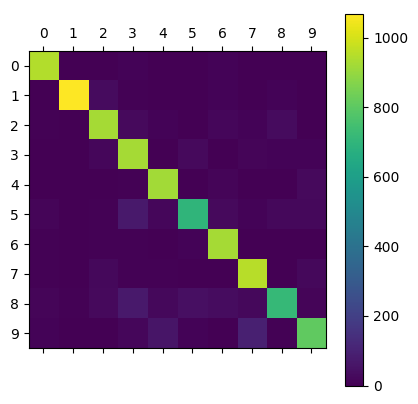

In [0]:
plot_mat(conf_mx)

On met des zéro sur la diagonale pour augmenter le contraste

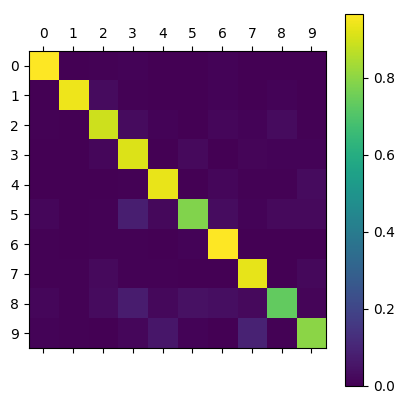

In [0]:
plot_mat(norm_conf_mx)

* Le 8 est souvent classé 3
* Le 5 est souvent classé 3
* Le 9 est trés souvent classé 7

Que peut-on faire

* rassembler plus de données correspondant à ces classes

* créer des features particulière qui permettent de les distinguer: ex: compter le nombre de composante connexe du complémetaire, ce qui différentie le 8, le 9, et le 5. Mais là on sort un peu du machine learning pour revenir aux algos classiques. 

* Observer individuellement les erreurs pour voir s'il n'y a pas de problèmes d'étiquette, de valeurs abhérentes, des problèmes de normalisation etc. 



### En couleur et en nombre

Ce programme pourra vous servir un jour (vous pourrez même l'adapter). 

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize,
                          title,
                          cmap="jet",
                          precision=2,
                         ):
        
    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)    
    np.set_printoptions(precision=precision)
    
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    print("Confusion matrix, without normalization:")
    print(cm)
    
    if normalize:        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(cm)
    
        
    fig, ax = plt.subplots(figsize=(8,8))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()    
    #fig.savefig(DIR_OUT+"/"+title)

Confusion matrix, without normalization:
[[ 947    0    4    9    1    3   10    2    2    2]
 [   0 1069   32    6    0    4   10    2   10    2]
 [   7    0  923   28   10    1   17   11   31    4]
 [   3    0   18  924    3   26    3   14   10    9]
 [   3    0    3    5  919    0   16    4    4   28]
 [  14    2    6   72   18  698   28   10   22   22]
 [   7    2    6    6    3    9  924    0    1    0]
 [   5    4   24    6    6    2    0  955    3   23]
 [  15    7   28   73   21   43   34   24  715   14]
 [   9    4    2   17   60    9    1   94    7  806]]
Normalized confusion matrix
[[0.97 0.   0.   0.01 0.   0.   0.01 0.   0.   0.  ]
 [0.   0.94 0.03 0.01 0.   0.   0.01 0.   0.01 0.  ]
 [0.01 0.   0.89 0.03 0.01 0.   0.02 0.01 0.03 0.  ]
 [0.   0.   0.02 0.91 0.   0.03 0.   0.01 0.01 0.01]
 [0.   0.   0.   0.01 0.94 0.   0.02 0.   0.   0.03]
 [0.02 0.   0.01 0.08 0.02 0.78 0.03 0.01 0.02 0.02]
 [0.01 0.   0.01 0.01 0.   0.01 0.96 0.   0.   0.  ]
 [0.   0.   0.02 0.01 0.01 0.

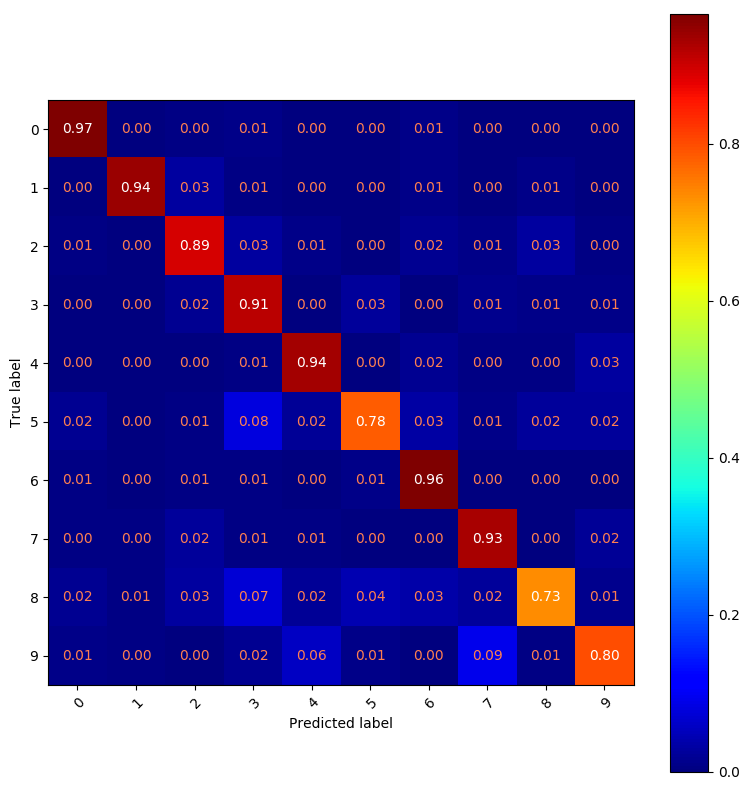

In [0]:
plot_confusion_matrix(y_test,hat_y_test, np.array([0,1,2,3,4,5,6,7,8,9]),True,"matrice de confusion")

### Observation individuelle des erreurs

In [0]:
cl_a, cl_b = 3, 5
X_ab = X_test[(y_test == cl_a) & (hat_y_test == cl_b)]
X_ba = X_test[(y_test == cl_b) & (hat_y_test == cl_a)]

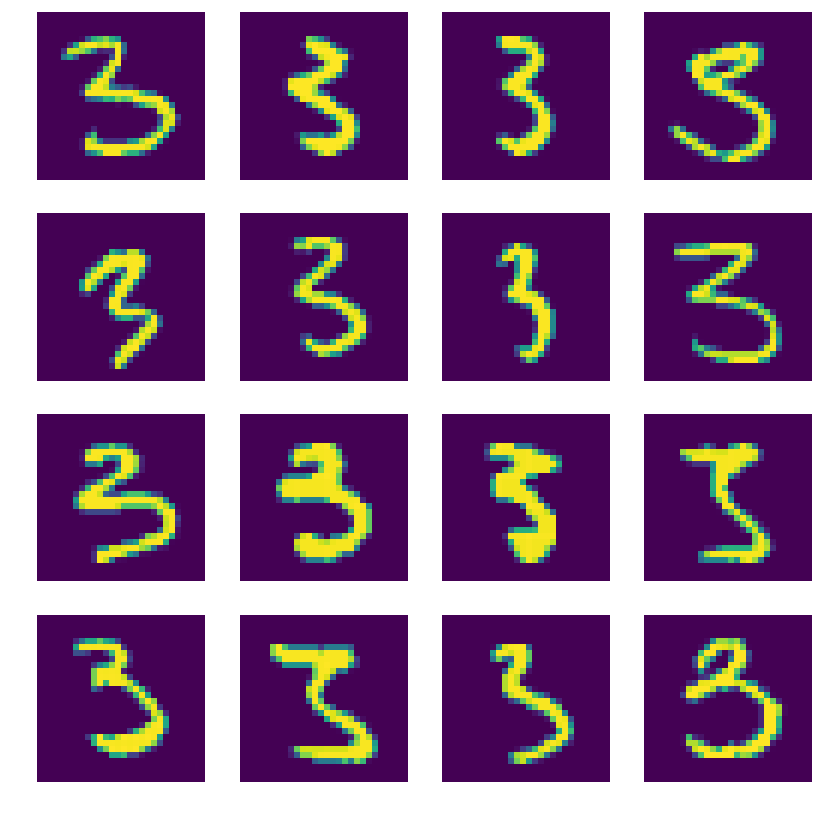

In [0]:
#observons des 3 qui ont été classé 5
fig,axs=plt.subplots(4,4,figsize=(10,10))
axs=axs.flatten()
for i,ax in enumerate(axs):
    ax.imshow(X_ab[i,:,:])    
    ax.axis("off")

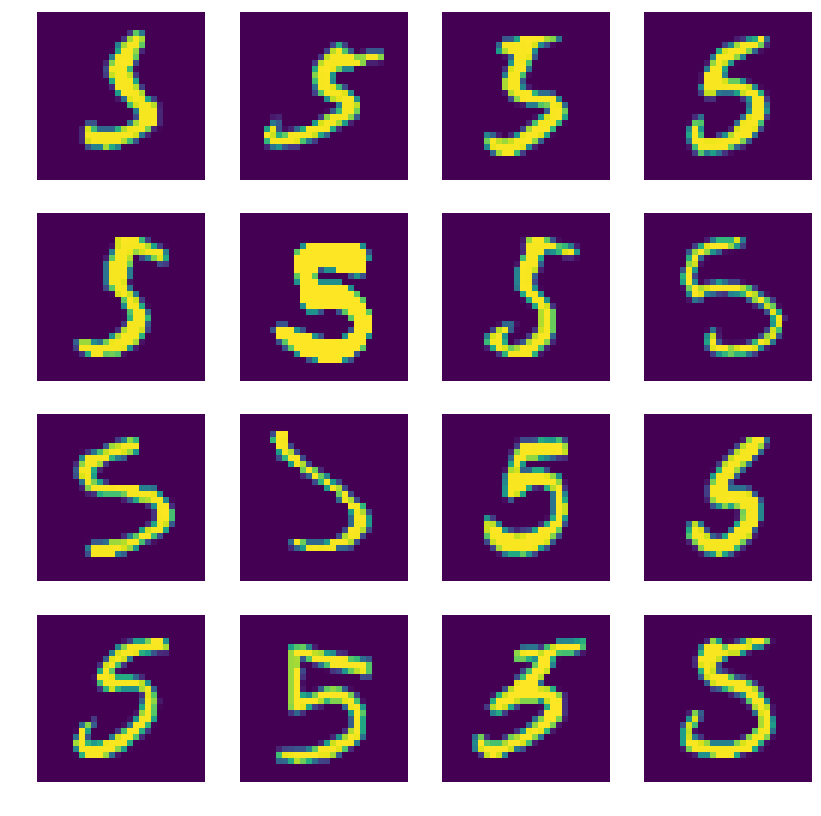

In [0]:
#observons des 5 qui ont été classé 3
fig,axs=plt.subplots(4,4,figsize=(10,10))
axs=axs.flatten()
for i,ax in enumerate(axs):
    ax.imshow(X_ba[i,:,:])    
    ax.axis("off")

### Un modèle trop simple ? 

Certaines erreurs viennent du fait que les chiffres ont été mal écrit, ou mal étiquetés. 

D'autre erreur viennent du fait  que le SGDClassifier n'est qu'un bête modèle linéaire. Détaillons son fonctionnement.  

*  Lors de l'apprentissage, pour chaque classe $k\in \{0,1,2,3,4,5,6,7,8,9\}$ le modèle apprend une matrice de poids $w_k[i,j]$ et un biais $b_k$. Par exemple, la matrice $w_0$ peut être considérer comme des templates (=masque pondérateur), avec des poids importants sur les pixels caractéritiques des 0 manuscrits. 


* Quand le modèle voit une nouvelle image $x[i,j]$, il superpose les templates avec cette image et calcule des scores:
$$
score_k = b_k +  \sum_{i,j} x[i,j]w_k[i,j]   
$$
La classe $\hat k$ choisie est celle qui a le plus grand score. Et si on veut un proba il faut passer au softmax (mais cela ne sert à rien ici). 



Remarque: si vous regarder le détail des codes, le `SGCClassifier` ne veut pas des matrices en entrées, mais des vecteurs. On utilise donc une version applatie des images, et la matrice des poids est en fait un vecteur. Notamment, la structure 2d de l'image n'est pas du tout exploité! On vera plus tard que les modèles à base de convolution sont bien plus efficaces (accuracy de 99,9%). 




In [0]:
#observons des templates
w=sgd_clf.coef_
b=sgd_clf.intercept_
w.shape,b.shape

((10, 784), (10,))

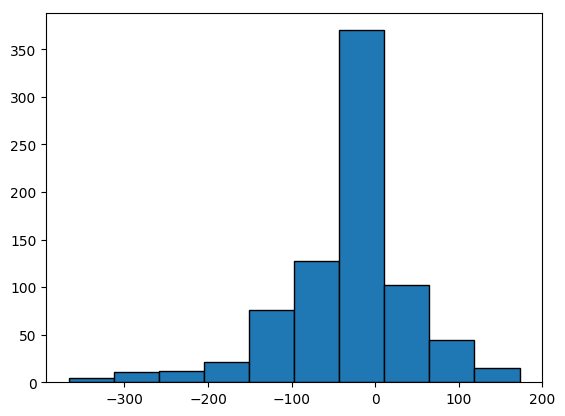

In [0]:
plt.hist(w[0,:],edgecolor="k");

$(1\heartsuit)$ Ces coefficients sont très grand... pourquoi ? 

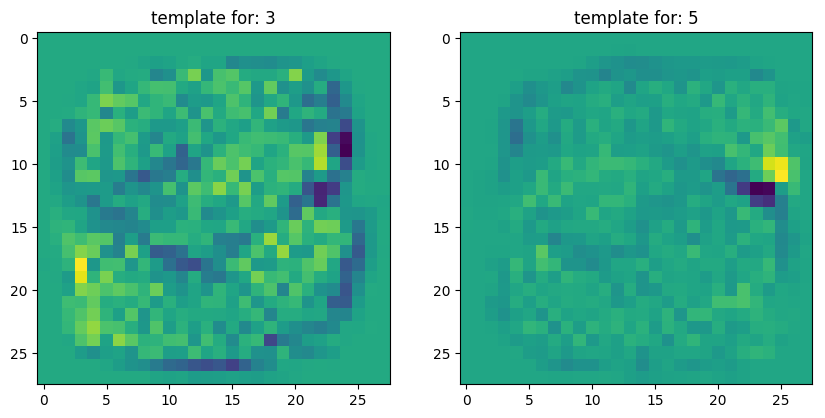

In [0]:
def plot_coefs(ax,cl):
    coef=sgd_clf.coef_[cl,:]
    coef=coef.reshape([28,28])
    ax.imshow(coef)
    ax.set_title("template for: "+str(cl))
    
  
fig,(ax0,ax1)=plt.subplots(1,2,figsize=(10,5))
plot_coefs(ax0,3)
plot_coefs(ax1,5)

Remarque: dans le template du 3,  il y a une ombre bleu: le modèle repère une image de 3 gràce à son "contour" non déssiné. En particulier, si vous écrivez un 3 très épais, qui déborde sur le contour du template, il ne sera pas classé comme un trois. 

### Une template, ce n'est pas qu'une moyenne

Remarquons que le template de 3 n'est pas une simple moyenne des images de 3. La preuve:

In [0]:
X_trois=X_train[y_train==3,:,:]
X_trois_mean=np.mean(X_trois,axis=0)
X_trois_mean.shape

(28, 28)

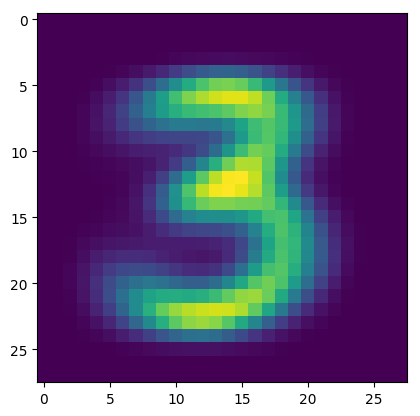

In [0]:
plt.imshow(X_trois_mean);

***A vous:*** $(10\heartsuit)$ Crée un classifier basé sur des templates de moyenne comme ci-dessous. Comparez-le au `SGDClassifier`


Remarque: les réseaux de neurones convolutif, classifie les images à partir de centaines de templates, pouvant avoir des résolutions variées. Mais le mot "template" n'est pas utilisé, on partle plutôt de "feature" ; mais ce mot est utilisé à toute les sausses. 

##  Classification Multilabel 

Parfois on doit poser plusieurs étiquette sur une même donnée. ex:

* Une donnée = une photo avec plusieur visage. Les étiquettes:  "présence d'un homme", "présence d'une femme".  
* Une donnée = une photo avec 1 animal. Les étiquettes:  mamifère, insecte, lion, chat, mouche: ce sont des catégories non-disjointes. 


###  Création des données

In [0]:
def make_multi_label(y):    
    y_large = (y >= 7).astype(np.int)
    y_odd = (y % 2 == 1).astype(np.int)
    y_multilabel = np.stack([y_large, y_odd],axis=1)
    return y_multilabel

y_multi_train=make_multi_label(y_train)
y_multi_test=make_multi_label(y_test)

print(y_multi_train[:10])

[[0 1]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]]


* La première colonne indique si un nombre est grand (7, 8, or 9) 
* La seconde colonne indique si un nombre est impair 

### Avec un arbre de décision

In [0]:
tree_clf = sklearn.tree.DecisionTreeClassifier()
tree_clf.fit(X_train_flat, y_multi_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
hat_y_multi_test=tree_clf.predict(X_test_flat)

In [0]:
print(hat_y_multi_test[:20].T)
print(y_multi_test[:20].T)

[[1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0]
 [1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0]]
[[1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0]
 [1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0]]


Pour évaluer une telle prédiction, on peut par exemple calculer le F1-score de chaque label. Puis sommer ces score, en mettant des pondération si une catégorie est plus importante que l'autre. 

On peut aussi calculer l'accuracy "sévère": une prédiction est bonne si toutes les étiquettes sont bonnes. 

Attention: pour le multi-label, d'une librairie à l'autre, le mot accuracy n'as pas toujours la même signification. Lisez la doc!


##  Classification  Multi-output

Cela regroupe deux choses:

* L'output est multi-dimensionnel; ex: c'est une image Y de même résolution que l'input. Et Y[i,j] = 0,1,2,3 selon si X[i,j] est un pixel de route, de maison, d'humain, d'arbre. 


* L'output est multi-dimensionnel et chaque élément de l'output peut-être multi-label



Pour illustrer cela, construisons un système qui supprime le bruit des images. L'input sera une image de chiffre bruité, l'output sera l'image sans le bruit. Chaque pixel de l'output sera dans une des classes 0,1,2,...,255


***Remarque:***  On est alors dans un cas intermédiaire entre classification et regression. 

### Créons les données


In [0]:
def add_noise(X):
    noise = np.random.randint(0, 100, (len(X), 28,28))
    noise2= 200*(np.random.uniform(0,1,(len(X), 28,28))<0.2)
    return X+noise+noise2

X_noise_train=add_noise(X_train)
X_noise_test=add_noise(X_test)
Y_noise_train=X_train
Y_noise_test=X_test

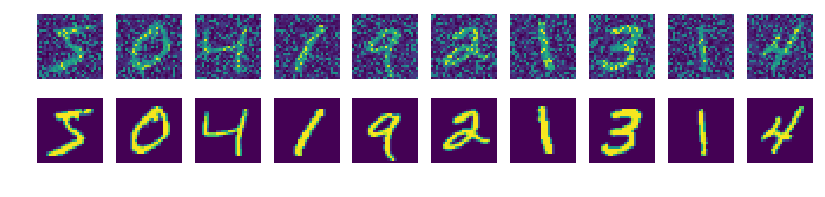

In [0]:
nb=10
fig,axs=plt.subplots(2,nb,figsize=(nb,2))

for i in range(nb):
    axs[0,i].imshow(X_noise_train[i,:,:])
    axs[0,i].axis("off")
    axs[1,i].imshow(Y_noise_train[i,:,:])
    axs[1,i].axis("off")

In [0]:
def flat(A):
    return A.reshape([-1,28*28])

knn_clf=sklearn.neighbors.KNeighborsClassifier()
knn_clf.fit(flat(X_noise_train), flat(Y_noise_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
nb=10
hat_Y_noise_test = knn_clf.predict(flat(X_noise_test[:nb]))

In [0]:
hat_Y_noise_test=hat_Y_noise_test.reshape([-1,28,28])

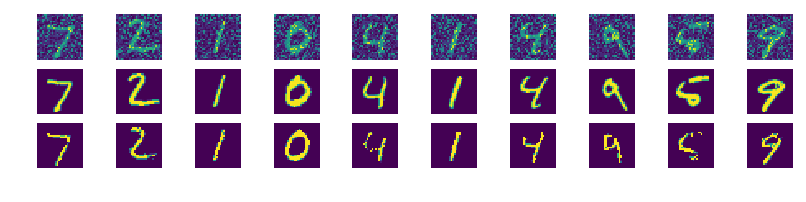

In [0]:
fig,axs=plt.subplots(3,nb,figsize=(nb,2))

for i in range(nb):
    axs[0,i].imshow(X_noise_test[i,:,:])
    axs[0,i].axis("off")
    axs[1,i].imshow(Y_noise_test[i,:,:])
    axs[1,i].axis("off")
    axs[2,i].imshow(hat_Y_noise_test[i,:,:])
    axs[2,i].axis("off")

***A vous:*** $(3\heartsuit)$ Augmenter l'intensité du bruit, pour voir la robustesse de ce mode de débruitage. 

 
Quel modèle peut-on utiliser pour faire du Multi-classe, multi-lable, multi-output? La réponse, ici: 
[Here](http://scikit-learn.org/stable/modules/multiclass.html)
